# Algorithm Benchmarking with QASM Simulations

The purpose of this notebook is to evaluate the performance of the implemented quantum time evolution algorithm. The common evaluated criteria are circuit depth and state fidelity. For QASM simulations, the metrics to be evaluated are

> 1. **Circuit depth**
> 1. **Trace distance**

In this notebooks, data is generated using Qiskit, and analyzed to find an expected relation between _evolution time_, _expected fidelity_ and _number of integration steps_. So first, It is wise to start with a little summary about the general results of quantum time evolution as presented by [1], then proceed to demonstrate how to use the devised routines for simulating a generic spin graph, and finally, produce some plots that show the actual performance of the programmed algorithm.

## General Quantum Time Simulation Theory

In this project, a second order Trotter scheme is proposed to estimate evolution of a spin system. Consider a Hamiltonian that can be written as the sum of _local Hamiltonians_ (acting on a small subsystem at a time).

$$
\hat{H} = \sum_{i=1}^{l} \hat{H}_i
$$

By direct computation, it is possible to show that

$$
\mathrm{e}^{-\mathrm{i}t\hat{H}} = \prod_{i=1}^{l} \mathrm{e}^{-\mathrm{i}t\hat{H}_i} + \mathcal{O}(t^2)
$$

Now, if evolution is carried out over a small enough period of time, then the difference between the right hand side and the left hand side is small. This leads to an integration scheme that relies on the implementation of local evolution operators, that is capable of simulate complex correlation in a quantum system, as long as it arises from small-subsystem interactions.

### Efficiency of Quantum Time Simulation Algorithms

Berry et. atl. [1] have already considered the general error theory of Suzuki-Trotter schemes, and te minimal amount of resources required to simulate a quantum system. First, let's discuss the expected number of operations required to obtain a desired error bound, for a given simulation time, and then, the minimal amount of resources required to simulate a given quantum system.

In their paper, Berry et. al. demonstrate that the expected number of steps (as measured by the number of exponentials required to implement a $k$-th order Suzuki-Trotter scheme) is bounded by a power law

$$
N \leq A_k \frac{t^{1+1/2k}}{\epsilon^{1/2k}}
$$

It is interesting, as they point out, that there is an optimal order for the integration scheme. However, the main takeaway here, at least by now, is that

> There exists a power law that relates the number of steps, integration time and error bound, or a given quantum system.

And so, this is what will be sought when benchmarking the proposed algorithm.

Finally, Berry et. al. point out that any Hamiltonian (at least of practical interest) may be simulated by a quantum algorithm using at least a linear amount of steps. Now, the remarkable part, at least for the purpose of this project is that

> If a simulation algorithm uses an amount of steps that scales linearly with time for given precision, then it is almost optimal. At least within a constant factor that can be optimized.

## Structure of the Notebook

This notebook is structured as follows. First, results obtained by Salathé et. al. and Las Heras et. al. are reproduced to show the correctness of the algorithms proposed. Simulations are carried out on `ibmq_quito`, and measurement error mitigation is implemented as well. After that, average quantum process fidelities of time evolution, over the model parameters, are computed for a system of 4 qubits. Simulations are carried out using `qasm_simulator` to assess the fault-tolerant limitations of the evolution algorithms proposed. Finally, quantum process fidelities are computed using a noisy model of `ibmq_quito` and QASM simulators, to assess the NISQ limitations of this algorithms.

Let's start by importing the necessary packages

In [1]:
from PyHeisenberg import HeisenbergGraph, DataAnalyzer, PulseSpinGraph
import numpy as np
import matplotlib.pyplot as plt
import warnings
from operator import itemgetter
warnings.filterwarnings('ignore')
plt.style.use('FigureStyle.mplstyle')

## Reproduction of results obtained by Salathé et. al.

In this section, a two-spin isotropic Heisenberg model is simulated using the networks proposed in the main document. This Hamiltonian corresponds to

$$
\hat{H} = J(\hat{X}_1\hat{X}_2 + \hat{Y}_1\hat{Y}_2 + \hat{Z}_1\hat{Z}_2)
$$

Following the group's work, the initial state

$$
|\psi_0\rangle = |+\rangle\otimes|0\rangle
$$

Is evolved for a time $t=3 \pi /4$, when $J = 1$. Time series of the expected values of single-qubit Pauli operators are generated and compared to results obtained by direct diagonalization of the Hamiltonian. The time interval is partitioned on $12$ equally spaced intervals.

### Definition of the Graph Object

As mentioned on the main text, the Hamiltonian gives rise to a graph that is used to store the information of the spin-spin and field-spin interactions. More parameters such as the execution backend, initial state and noise activation are included as well.

In [2]:
testGraph = HeisenbergGraph(
    spinInteractions={
        (0, 1): [1, 1, 1],
    },
    externalField={
        0: [0.0, 0.0, 0.0],
        1: [0.0, 0.0, 0.0],
    },
    localSimulation=False,
    backendName='ibmq_bogota',
    noisySimulation=False,
    initialState=1/np.sqrt(2) * np.array([1, 0, 1, 0])
)
testAnalyzer = DataAnalyzer(spinGraph=testGraph)

### Computation of Exact Evolution Time Series

These correspond to direct diagonalization using Numpy. By default, 200 steps are used for producing a somewhat smooth theoretical curve of the evolution of expected values of a Pauli string operator.

In [3]:
pauliStrings = ['XI', 'IX', 'YI', 'IY', 'ZI', 'IZ']
timesEx, resultSeriesExact = testGraph.exactPauliExpValSeries(
    pauliStrings,
    t = 3*np.pi/4
)
ExX1, ExX2, ExY1, ExY2, ExZ1, ExZ2 = itemgetter(*pauliStrings)(resultSeriesExact)

### Computation of Experimental Evolution Time Series

These correspond to quantum time simulation using algorithms descried on the main text. By default, 200 steps are used for producing a somewhat smooth experimental curve of the evolution of expected values of a Pauli string operator. Due to decoherence and gate errors, it is suggested that no more than 20 steps for simulating time evolution on real quantum devices.

To mitigate readout errors, a special technique is used. It uses a markovian model for correcting possible bit filp errors on readout. It is implemented on this notebook using `qiskit.ignis`.

#### Measurement error mitigation

To apply measurement error mitigation, generate a sequence of quantum circuits to measure the readout errors when preparing states of the computational basis. Then fit an evolution matrix for assessing the transition probabilities, and define a filter for correction results of future algorithm's execution. This is done by `qiskit.ignis`.

In [ ]:
measurementFitter = testGraph.getCalibrationFitter()

#### Computation of Time Series on IBM Quantum

Due to current limitations of cloud-based quantum computing, the `HeisenbergGraph` class optimizes the process of running quantum circuits on real quantum deices. It is recommended that the following routine be used for computing time series of expected value of Pauli string observables. The function returns `ndarray`s, which can be linearly combined to compute time series of generic quantum operators.

In [15]:
times, resultSeries = testGraph.pauliExpValSeries(
    pauliStrings,
    MAX_STEPS = 12,
    t = 3*np.pi/4,
    measurementFitter= measurementFitter
)
X1, X2, Y1, Y2, Z1, Z2 = itemgetter(*pauliStrings)(resultSeries)

Job Status: job has successfully run


What follows is to plot the experimental results. A comparative plot of theoretical values an experimental values is presented on this cell. Since time evolution of this system is exact, the experimental points (scatter plots) resemble quite well the theoretical curves (dashed lines). Red datasets corresponds to the second spin's observables, whereas the blu datasets corresponds to the first spin's observables.

**Important:** During simulations, the specifications of the QPU were

|$T_1$|$T_2$|CNOT err.|Readout err.|
|:-:|:-:|:-:|:-:|
|103.34 us|124.79 us|1.931e-2|3.070e-2|

Measurement error mitigation is optional. However, it is highly recommended. Since `Qiskit Runtime` is still on beta, this project doesn't rely on that architecture.

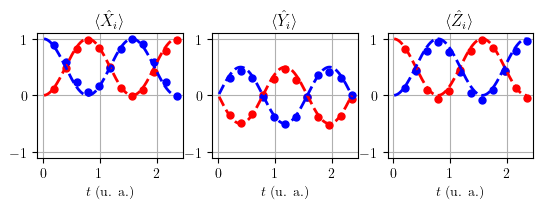

In [16]:
fig, (axX, axY, axZ) = plt.subplots(1,3)
axX.plot(times, X1, 'ro', times, X2, 'bo')
axX.plot(timesEx, ExX1, color='red', linewidth=2, linestyle='dashed')
axX.plot(timesEx, ExX2, color='blue', linewidth=2, linestyle='dashed')
axX.set_title(r"$\langle\hat{X}_i\rangle$")
axX.set_xlabel(r"$t$ (u. a.)")
axX.set_aspect('equal')
axX.set_ylim([-1.1, 1.1])
axY.plot(times, Y1, 'ro', times, Y2, 'bo')
axY.plot(timesEx, ExY1, color='red', linewidth=2, linestyle='dashed')
axY.plot(timesEx, ExY2, color='blue', linewidth=2, linestyle='dashed')
axY.set_title(r"$\langle\hat{Y}_i\rangle$")
axY.set_xlabel(r"$t$ (u. a.)")
axY.set_aspect('equal')
axY.set_ylim([-1.1, 1.1])
axZ.plot(times, Z1, 'ro', times, Z2, 'bo')
axZ.plot(timesEx, ExZ1, color='red', linewidth=2, linestyle='dashed')
axZ.plot(timesEx, ExZ2, color='blue', linewidth=2, linestyle='dashed')
axZ.set_title(r"$\langle\hat{Z}_i\rangle$")
axZ.set_xlabel(r"$t$ (u. a.)")
axZ.set_aspect('equal')
axZ.set_ylim([-1.1, 1.1])
plt.savefig('XYZModel.pdf')
plt.show()


## Reproduction of results of Las Heras et. al. and Salathé et. al.

In this section, the two-spin transverse field Ising model, 

$$
\hat{H} = \frac{V}{2}(\hat{X}_1\hat{X}_2 + \hat{Y}_1\hat{Y}_2 + \hat{Z}_1\hat{Z}_2) + \frac{U}{4}(\hat{Z}_1 + \hat{Z}_2)
$$

with $V = U = 1$, is simulated over a time $\tau = 5$. The initial state is set to

$$
|\psi_0\rangle = |+\rangle\otimes|0\rangle
$$

Simulations are carried out using `ibmq_quito`, and error correction. First, a graph object is instantiated with the desired parameter values ($J=1$). Spin interactions are defined as a dictionary with a tuple key that points the index of the involved sites, and a value that has the interaction parameters as defined on the main document. Filed interactions are described y a dictionary whose key is the site index, and its value is an iterable that has the cartesian components of the local field, as defined on the main text.

A comparative evolution plot is generated using the `dataAnalyzer` object. The number of Trotter steps is taken to be $N = 8$. However, this can be changed at will.

In [ ]:
isingGraph = HeisenbergGraph(
    spinInteractions={
        (0, 1): [0.5, 0.5, 0.5],
    },
    externalField={
        0: [0.0, 0.0, 0.25],
        1: [0.0, 0.0, 0.25],
    },
    localSimulation=False,
    backendName='ibmq_bogota',
    noisySimulation=False,
    initialState=1/np.sqrt(2) * np.array([1, 0, 1, 0])
)
isingAnalyzer = DataAnalyzer(spinGraph=isingGraph)

### Evolution of occupation number

Remember that each computational basis state can be mapped to an integer. This integer is shown on the plot legends. An excited fermionic mode is mapped to the ground state of a qubit $|1\rangle$, and the ground fermionic mode to the excited state of a qubit $|0\rangle$. Simulations were carried out on `ibmq_bogota`. Notice that, in this case, the occupation numbers are not so close to the theoretical values. This is due to many sources of errors. This will be addressed bellow. By now, those are stated

1. Readout error
1. Gate error (CNOT and $\pi/2$-pulses)
1. Qubit relaxation
1. Decoherence nd thermal relaxation

**Important:** During simulations, the specifications of the QPU were

|$T_1$|$T_2$|CNOT err.|Readout err.|
|:-:|:-:|:-:|:-:|
|103.34 us|124.79 us|1.931e-2|3.070e-2|

Job Status: job has successfully run


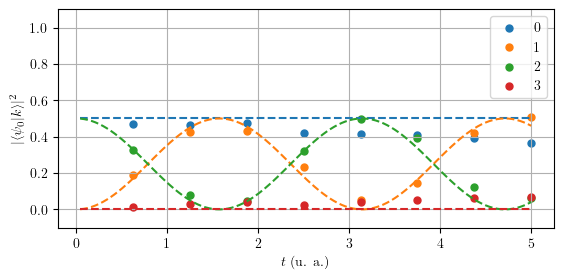

In [20]:
isingAnalyzer.comparativeEvolution(
    STEPS=8, 
    t=5.0,
    measurementFitter=measurementFitter
)
plt.savefig('HubbardTwoMode.pdf')

## Simulation of a 3-Spin $XXX$ model

As another way to demonstrate the utility of the trotterization scheme proposed, a three spin Hamiltonian

$$
\hat{H} = \sum_{i=0}^{1} \bigg(\hat{X}^{(i)}\hat{X}^{(i+1)} + \hat{Y}^{(i)}\hat{Y}^{(i+1)} + \hat{Z}^{(i)}\hat{Z}^{(i+1)} \bigg)
$$

Which is a generalization of the Hamiltonian simulated by Salathé et. al. Pretty much the same observables are measured. As before, a graph is instantiated, with the desired two-qubit interactions. SIMulations are carried out on `ibmq_jakarta`.

In [7]:
xGraph = HeisenbergGraph(
    spinInteractions={
        (0, 1): [1, 1, 1],
        (0, 2): [1, 1, 1],
    },
    externalField={
        0: [0.0, 0.0, 0.0],
        1: [0.0, 0.0, 0.0],
    },
    localSimulation=False,
    backendName='ibmq_jakarta',
    noisySimulation=False,
    initialState=1/np.sqrt(1) * np.array([1, 0, 0, 0, 0, 0, 0, 0])
)
xAnalyzer = DataAnalyzer(spinGraph=xGraph)

After, the exact evolution of the expected value of single qubit Pauli operators is computed

In [3]:
pauliStrings = ['XII', 'IXI', 'IIX', 'YII', 'IYI', 'IIY', 'ZII', 'IZI', 'IIZ']
timesEx, resultSeriesExact = xGraph.exactPauliExpValSeries(
    pauliStrings,
    t=3*np.pi/4
)
ExX1, ExX2, ExX3, ExY1, ExY2, ExY3, ExZ1, ExZ2, ExZ3 = itemgetter(
    *pauliStrings)(resultSeriesExact)

And a measurement error mitigation fitter is devised suited to the conditions of the backend.

In [8]:
measurementFitter = xGraph.getCalibrationFitter()

Job Status: job has successfully run


Finally, experimental data is captured on IBM Quantum's backend.

In [11]:
times, resultSeries = xGraph.pauliExpValSeries(
    pauliStrings,
    MAX_STEPS=5,
    t=3*np.pi/4,
    measurementFitter=measurementFitter
)
X1, X2, X3, Y1, Y2, Y3, Z1, Z2, Z3 = itemgetter(*pauliStrings)(resultSeries)

Job Status: job has successfully run


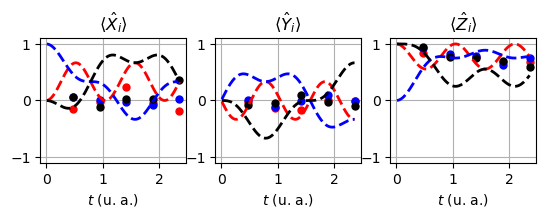

In [12]:
fig, (axX, axY, axZ) = plt.subplots(1, 3)
axX.plot(times, X1, 'ro', times, X2, 'bo', times, X3, 'ko')
axX.plot(timesEx, ExX1, color='red', linewidth=2, linestyle='dashed')
axX.plot(timesEx, ExX2, color='blue', linewidth=2, linestyle='dashed')
axX.plot(timesEx, ExX3, color='black', linewidth=2, linestyle='dashed')
axX.set_title(r"$\langle\hat{X}_i\rangle$")
axX.set_xlabel(r"$t$ (u. a.)")
axX.set_aspect('equal')
axX.set_ylim([-1.1, 1.1])
axY.plot(times, Y1, 'ro', times, Y2, 'bo', times, Y3, 'ko')
axY.plot(timesEx, ExY1, color='red', linewidth=2, linestyle='dashed')
axY.plot(timesEx, ExY2, color='blue', linewidth=2, linestyle='dashed')
axY.plot(timesEx, ExY3, color='black', linewidth=2, linestyle='dashed')
axY.set_title(r"$\langle\hat{Y}_i\rangle$")
axY.set_xlabel(r"$t$ (u. a.)")
axY.set_aspect('equal')
axY.set_ylim([-1.1, 1.1])
axZ.plot(times, Z1, 'ro', times, Z2, 'bo', times, Z3, 'ko')
axZ.plot(timesEx, ExZ1, color='red', linewidth=2, linestyle='dashed')
axZ.plot(timesEx, ExZ2, color='blue', linewidth=2, linestyle='dashed')
axZ.plot(timesEx, ExZ3, color='black', linewidth=2, linestyle='dashed')
axZ.set_title(r"$\langle\hat{Z}_i\rangle$")
axZ.set_xlabel(r"$t$ (u. a.)")
axZ.set_aspect('equal')
axZ.set_ylim([-1.1, 1.1])
fig.savefig('XYZModel.pdf')
plt.show()


As is readily seen, the results are poor. Specially for a large number of integration steps. The reason for this is decoherence and qubit relaxation. To the lowest level, quantum algorithms are implemented via microwave pulses acting on a superconducting chip. The duration of hose pulses, and its relation to coherence and qubit relaxation times, determines the fidelity of the evolution. The longer the pulse schedule that implements the algorithm, the worse the fidelity. Although the evolution algorithm here implemented is _basis efficient_, i. e. uses a small number of CNOT gates and single qubit rotations per integration step, it is not _pulse efficient_, i. e. the actual sequence of microwave pulses implemented on hardware is simply to long and decoherence and qubit relaxation prevent high fidelities.

A more intelligent approach relies on implementations that not only are simple in the high level circuit model abstraction, but also imply a reduced the duration of its associated pulse schedule. IBM Quantum devices implement standard single qubit rotations with relatively high precision, and the bottleneck is mostly due to two-qubit gates. Such interactions are performed on hardware via **Cross-Resonance gates**

$$
\hat{R}_{zx}(\phi) = \mathrm{e}^{-\mathrm{i}\phi\hat{Z}\otimes\hat{X}}
$$

> Although IBM Quantum devices have a universal set that uses CNOT as entangling gate, on hardware, actual hardware, two-qubit interactions are performed via cross-resonance 

Notice that cross-resonance is very similar to the terms in the Hamiltonian, up to single qubit rotations. So, this seems to be the key for simulating spin systems with higher fidelity. This approach will be explored further in the future. By now, the limits of the proposed Trotterization scheme, and its relation with the target dynamics is discussed further.

### Simulation using Cross Resonance gates

In this section, an evolution algorithm based on the cross resonance gate described above is tested. This is part of the Open Science Challenge from IBM. The first approach consists on using the `PassManager` object for preventing transpilation of RZX gates to basis gates, thus implementing them directly on hardware using microwave pulses. From trotterization benchmark, I have seen that at least a time step $dt \approx 0.2 \text{ u. a.}$ should be used for simulations to produce decent outcome. This is related to the particular Floquet dynamics at large time step.

In [ ]:
pGraph = PulseSpinGraph(
    spinInteractions={
        (0, 1): [1, 1, 1],
        (1, 2): [1, 1, 1],
    },
    externalField={
        0: [0.0, 0.0, 0.0],
        1: [0.0, 0.0, 0.0],
    },
    localSimulation=False,
    backendName='ibmq_jakarta',
    noisySimulation=False,
    initialState=1/np.sqrt(2) * np.array([1, 0, 1, 0, 0, 0, 0, 0])
)
pAnalyzer = DataAnalyzer(spinGraph=pGraph)

In [3]:
pauliStrings = ['XII', 'IXI', 'IIX', 'YII', 'IYI', 'IIY', 'ZII', 'IZI', 'IIZ']
timesEx, resultSeriesExact = pGraph.exactPauliExpValSeries(
    pauliStrings,
    t=3*np.pi/4
)
ExX1, ExX2, ExX3, ExY1, ExY2, ExY3, ExZ1, ExZ2, ExZ3 = itemgetter(
    *pauliStrings)(resultSeriesExact)

In [8]:
measurementFitter = pGraph.getCalibrationFitter()

Job Status: job has successfully run


In [ ]:
times, resultSeries = pGraph.pauliExpValSeries(
    pauliStrings,
    MAX_STEPS=10,
    t=3*np.pi/4,
    measurementFitter=measurementFitter
)
X1, X2, X3, Y1, Y2, Y3, Z1, Z2, Z3 = itemgetter(*pauliStrings)(resultSeries)

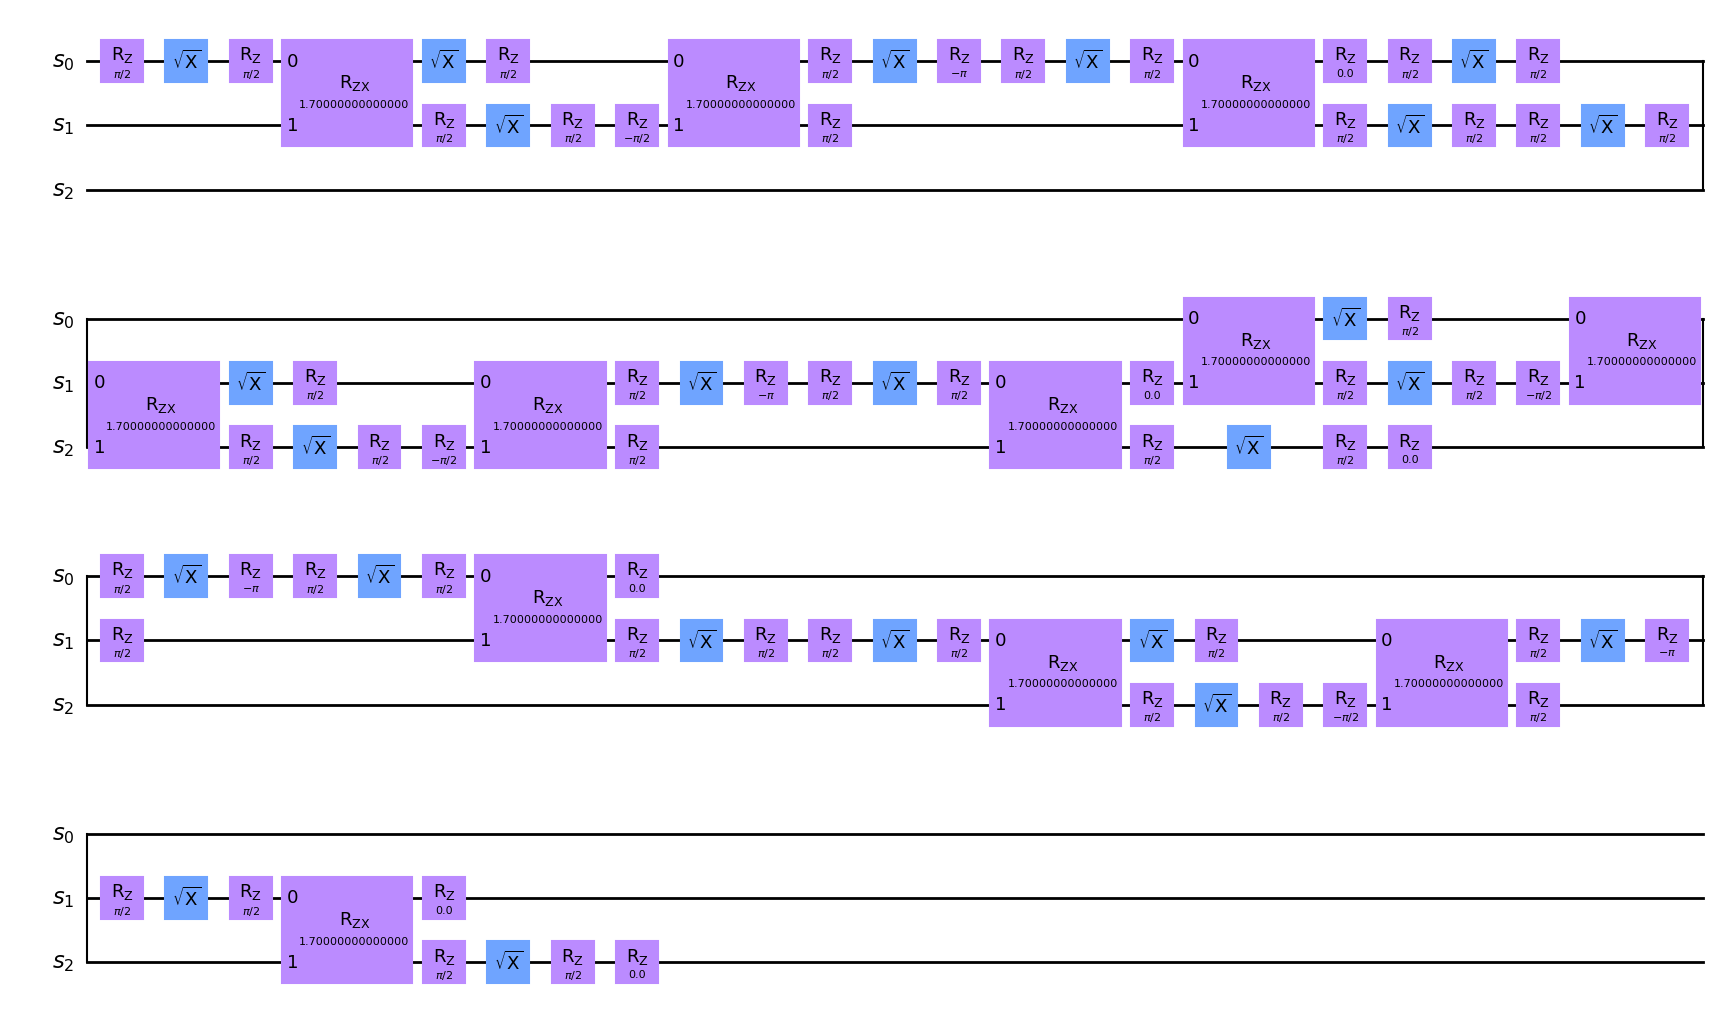

In [16]:
demoCircuit = pGraph.rawEvolutionCircuit(STEPS=2)
demoCircuit.decompose().draw(output="mpl")

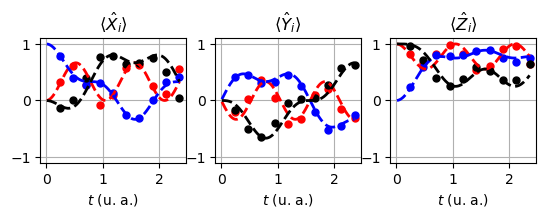

In [6]:
fig, (axX, axY, axZ) = plt.subplots(1, 3)
axX.plot(times, X1, 'ro', times, X2, 'bo', times, X3, 'ko')
axX.plot(timesEx, ExX1, color='red', linewidth=2, linestyle='dashed')
axX.plot(timesEx, ExX2, color='blue', linewidth=2, linestyle='dashed')
axX.plot(timesEx, ExX3, color='black', linewidth=2, linestyle='dashed')
axX.set_title(r"$\langle\hat{X}_i\rangle$")
axX.set_xlabel(r"$t$ (u. a.)")
axX.set_aspect('equal')
axX.set_ylim([-1.1, 1.1])
axY.plot(times, Y1, 'ro', times, Y2, 'bo', times, Y3, 'ko')
axY.plot(timesEx, ExY1, color='red', linewidth=2, linestyle='dashed')
axY.plot(timesEx, ExY2, color='blue', linewidth=2, linestyle='dashed')
axY.plot(timesEx, ExY3, color='black', linewidth=2, linestyle='dashed')
axY.set_title(r"$\langle\hat{Y}_i\rangle$")
axY.set_xlabel(r"$t$ (u. a.)")
axY.set_aspect('equal')
axY.set_ylim([-1.1, 1.1])
axZ.plot(times, Z1, 'ro', times, Z2, 'bo', times, Z3, 'ko')
axZ.plot(timesEx, ExZ1, color='red', linewidth=2, linestyle='dashed')
axZ.plot(timesEx, ExZ2, color='blue', linewidth=2, linestyle='dashed')
axZ.plot(timesEx, ExZ3, color='black', linewidth=2, linestyle='dashed')
axZ.set_title(r"$\langle\hat{Z}_i\rangle$")
axZ.set_xlabel(r"$t$ (u. a.)")
axZ.set_aspect('equal')
axZ.set_ylim([-1.1, 1.1])
fig.savefig('XYZModel.pdf')
plt.show()

## Appendix: Trotterization Benchmark

What follows is a benchmark that is designed to assess the quality of the evolution algorithm. On a first stage, the asymptotic behavior is studied in terms of the actual unitary. In particular, the actual relation between evolution error, total time evolution, and number of integration steps is computed for a representative benchmark Hamiltonian. After that, the dynamics induced by trotterization scheme is compared to the actual dynamics, for a particular initial state, as a function of the integration step $dt = t/N$. Long time evolution averages are used to illustrate possible differences. The size of the system is varied so as to characterize the erformance of the algorithm as a function of this parameter.

### Benchmark Hamiltonian

The benchmark Hamiltonian is of the shape

$$
\hat{H} = \sum_{i=0}^{\mathcal{N}-2} \bigg(\frac{1}{2}\hat{X}^{(i)}\hat{X}^{(i+1)} + \hat{Y}^{(i)}\hat{Y}^{(i+1)} + \frac{1}{4}\hat{Z}^{(i)}\hat{Z}^{(i+1)} \bigg) + \sum_{i=0}^{\mathcal{N}-1} \bigg(\hat{X}^{(i)} + \frac{1}{4} \hat{Y}^{(i)} + \frac{1}{2} \hat{Z}^{(i)} \bigg)
$$

This corresponds to an $XYZ$ Model, with an external field constant across the chain, and with non-periodic boundary conditions. The size of the system $\mathcal{N}$ may be varied arbitrarily. However, it is suggested that sizes no larger than $\mathcal{N} = 8$ be used on standard machines. Evolution of large systems is qte resource demanding (obviously). Although this exact notebook was used for data generation throughout the project, execution times tend to be quite large, and thus unless they are sought to be reproduced exactly, it is advised that the reader restricts the system's size for simple demos.

## Asymptotic Analysis of Evolution Precision

In this section, a benchmark model is used for studying the Trotterization scheme performance at very small step sizes. Previous work predict a power law that relates

1. Evolution unitary error ($\epsilon$)
1. Number of integration steps ($N$)
1. Total simulation time ($t$)

The Trotterization scheme proposed in this project produces a unitary $\hat{U}_N(t)$, that approximates the exact evolution unitary

$$
\hat{U}(t) = \mathrm{e}^{-\mathrm{i}\hat{H}t}
$$

### Studying a sample

In this section a 5 spin system is used to evaluate the evolution error as a function of both $t$ and $N$. Here

$$
\epsilon = ||\hat{U}_N(t) - \hat{U}(t)||
$$

Where the distance is simply the Frobenius norm. The results are evaluated using QASM simulator. Both time and number of integration steps are varied to determine a power law that predicts the asymptotic error for large times .

In [4]:
numSpins = 6
benchmarkGraph = HeisenbergGraph(
    spinInteractions={
        (idx, idx+1): [0.5, 1.0, 0.25]
        for idx in range(numSpins-1)
    },
    externalField={
        idx: [1.0, 0.25, 0.5]
        for idx in range(numSpins)
    },
    localSimulation=True,
    backendName='qasm_simulator',
    noisySimulation=False,
    initialState=np.array([1 if idx == 1 else 0 for idx in range(2**numSpins)])
)
benchmarkAnalyzer = DataAnalyzer(spinGraph=benchmarkGraph)


#### Results and dscussion

After computing errors, for this sample system, it is noticed that there is in fact a power law that describes the asymptotic error. In fact, linear regressions are performed to determine the exponents. Bellow, a plot confirming this fact is presented.

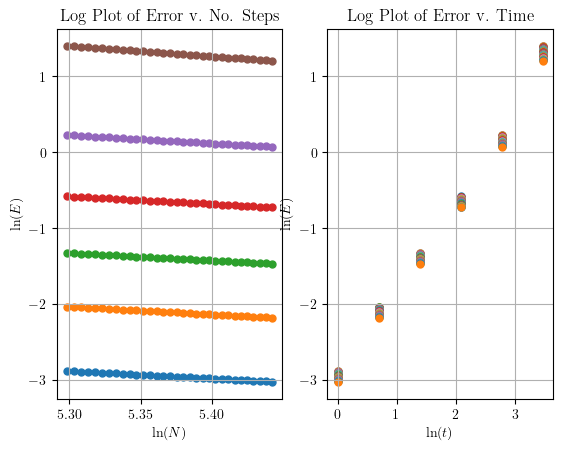

In [5]:
sim = benchmarkAnalyzer.unitaryErrorMixedPlot(
    STEPS = np.array([idx for idx in range(200, 232)]),
    times = [1,2,4,8,16,32]
)

In the following cells, linear regressions are performed, and exponents can be seen for different times and number of steps. The data suggests that

$$
\epsilon \approx A \frac{t^{\frac{6}{5}}}{N}
$$

In this asymptotic regime. This shows that although Berry et. al. produce a relatively tight bound for the Trotterization error, the actual computational complexity is better than the predicted by those computations, at least for the type of systems considered in this work. Since circuit depth scales linearly with the number of integration steps. However, this behavior is only asymptotic. It will be shown in following cells that the dynamics for a small number of integration steps and large times is fairly erratic, and there is a clear convergence radius that marks the onset of the asymptotic behavior.

**Note:** The following cells contain the results of the regressions.

In [7]:
from scipy.stats import linregress
import pandas as pd
from IPython.display import display
STEPS = np.array([idx for idx in range(200, 232)])
times = [1, 2, 4, 8, 16, 32]
columns = ["slope", "intercept", "r-value", "p-value", "std-err"]
stepRows = [f"t={t}" for t in times]
timeRows = [f"N={n}" for n in STEPS]

In [8]:
stepsLinregress = [
    [
        item
        for item in linregress(
            np.log(STEPS),
            np.log(sim[idx, :])
        )
    ]
    for idx in range(len(times))
]
stepDf = pd.DataFrame(
    data=stepsLinregress,
    index=stepRows,
    columns=columns
)
display(stepDf)

,slope,intercept,r-value,p-value,std-err
t=1,-1.000033,2.415382,-1.000000,8.642650e-189,1.048778e-07
t=2,-0.999982,3.260707,-1.000000,2.989916e-187,1.180216e-07
t=4,-1.000372,3.971356,-1.000000,7.748542e-150,2.085690e-06
t=8,-1.005337,4.742891,-1.000000,2.448726e-113,3.451890e-05
t=16,-1.066622,5.872705,-0.999998,1.547176e-81,4.205103e-04
t=32,-1.364227,8.624357,-0.999990,4.768404e-72,1.114168e-03


In [10]:
timesLinregress = [
    [
        item
        for item in linregress(
            np.log(times),
            np.log(sim[:, idx])
        )
    ]
    for idx in range(len(STEPS))
]
timesDf = pd.DataFrame(
    data=timesLinregress,
    index=timeRows,
    columns=columns
)
display(timesDf.head(6))

,slope,intercept,r-value,p-value,std-err
N=200,1.192165,-2.935006,0.996322,0.000020,0.051267
N=201,1.191721,-2.939612,0.996346,0.000020,0.051078
N=202,1.191281,-2.944198,0.996370,0.000020,0.050891
N=203,1.190845,-2.948762,0.996394,0.000019,0.050706
N=204,1.190413,-2.953305,0.996417,0.000019,0.050522
N=205,1.189985,-2.957828,0.996440,0.000019,0.050340


### Trotter dynamics

As mentioned before, the asymptotic behavior is preceded by a more erratic dynamics. In this section, this is characterized by two metrics: **Long time average fidelity** and **Inverse participation ration**, defined as follows

$$
\mathcal{F}_{\infty} = \lim_{n \rightarrow \infty} \sum_{i = 1}^N |\langle\psi_0|\hat{U}(t)^\dagger\hat{U}_N(t)|\psi_0\rangle|^2
$$

$$
\text{IPR} = \sum_{n} |\langle\phi_n|\psi_0\rangle|^4
$$

Where $|\psi_0\rangle$ is the initial state of the system, and

$$
\hat{U}_N(t)|\phi_n\rangle = \mathrm{e}^{-\mathrm{i}E_n t}|\phi_n\rangle
$$

These quantities are studied as a function of the _integration step_ $dt = t/N$. 

#### Study of Long Time Average Fidelity

Data has been generated using `floquetDataGeneration.py`. The algorithm is based upon diagonalization with NumPy. This may not be the best algorithm, however, this was the best option given my knowledge of scientific computing on python. The datasets are computed for chains of sizes $2$, $4$, $6$, and $8$. Data can be found on `../datafiles/FloquetData`.

In the following cell, ndarrays are generated with the simulation results

In [15]:
spinVals = [2, 4, 6, 8]
datasets = [
    np.genfromtxt(
        f"../datafiles/FloquetData/sampleData_{spins}spins.csv",
        delimiter=","
    )
    for spins in spinVals
]

Mow, plots for different spin values are generated

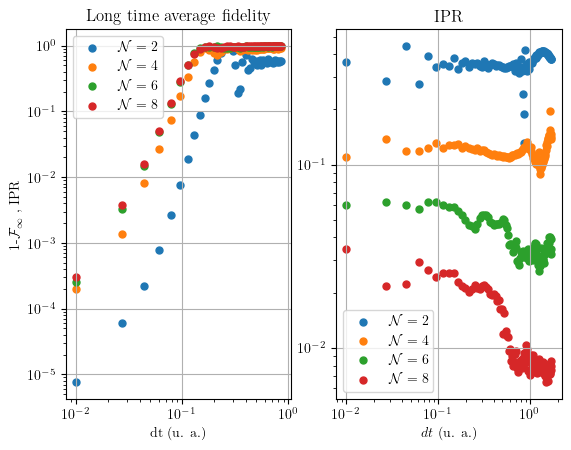

In [29]:
figFloq, (axFid, axIPR) = plt.subplots(1,2)
axFid.set_xlabel("dt (u. a.)")
axFid.set_xscale("log")
axFid.set_yscale("log")
axFid.set_title("Long time average fidelity")
axFid.set_ylabel(r"1-$\mathcal{F}_{\infty}$ , IPR")
axIPR.set_xlabel("$dt$ (u. a.)")
axIPR.set_xscale("log")
axIPR.set_yscale("log")
axIPR.set_title("IPR")
for idx, spin in enumerate(spinVals):
    axFid.scatter(
        datasets[idx][0:50, 0], 
        1-datasets[idx][0:50, 1], 
        label=r"$\mathcal{N}$" + f" = {spin}"
    )
    axIPR.scatter(
        datasets[idx][:, 0], 
        datasets[idx][:, 2],
        label=r"$\mathcal{N}$" + f" = {spin}"
    )
axIPR.legend()
axFid.legend()
plt.show()


#### Results and discussion

From the $\mathcal{F}_{\infty}$ plot, it can be seen that there is a sharp change of regime for time steps $dt < 0.2$ approximately. There, the asymptotic regime is quite visible, whereas for larger time steps, the average fidelity is almost zero, which seems to suggest that there is a quite different time evolution below this threshold.

**Note:** It is important to understand better how to describe the dynamics in terms of quantum chaos. Due to the normalization of the wavefunction, trajectory divergency saturates. Therefore, measures of quantum chaos should be studied carefully and addressed better here.

Also, it is desirable to perform finite size scaling, to determine the large system critical time step below which deterministic dynamics occur. However, data looks weird, and may need be repeated.